In [1]:
import os
import sys
import glob as glob
import numpy as np
import datetime
import cv2
import keras
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import SGD
import tensorflow
from scipy.interpolate import spline
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
keras.__version__

'1.2.2'

In [3]:
tensorflow.__version__

'0.12.0'

In [4]:
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

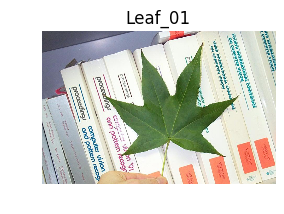

In [5]:
img = load_img('images/leaf_01/image_0027.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Leaf_01')
plt.show()

In [6]:
x = img_to_array(img)
x2 = x.reshape((1,) + x.shape)

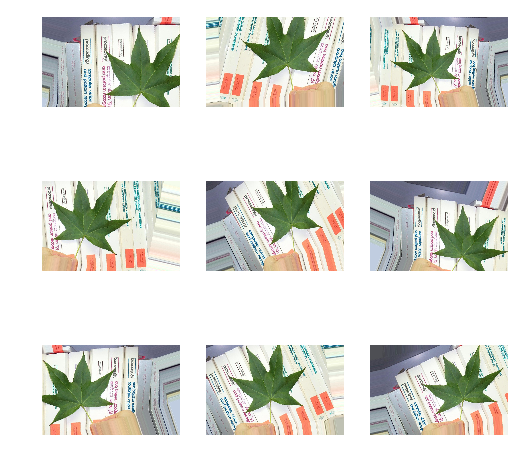

In [7]:
i = 0
fig = plt.figure(figsize = (6,6))
plt.title('Pre-processed')
for batch in datagen.flow(x2, batch_size = 1):
    i += 1
    if i > 9:
        break
    temp = batch.reshape(x.shape)
    plt.subplot(3, 3, i)
    plt.imshow(temp.astype('uint8'))
    plt.axis('off')
plt.show()

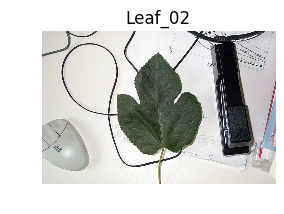

In [8]:
img = load_img('images/leaf_02/image_0110.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Leaf_02')
plt.show()

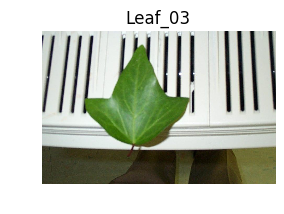

In [9]:
img = load_img('images/leaf_03/image_0153.jpg')
plt.figure(figsize = (3,3))
plt.imshow(img)
plt.axis('off')
plt.title('Leaf_03')
plt.show()

In [10]:
# default settings
img_width, img_height = 299, 299

train_dir = 'data/train'
validate_dir = 'data/validate'
nb_epochs = 20 
batch_size = 64
nb_classes = len(glob.glob(train_dir + '/*'))

In [11]:
# get number of images in training directory
nb_train_samples = 0
for r, dirs, files in os.walk(train_dir):
    for dr in dirs:
        nb_train_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_train_samples)

125


In [12]:
# get number of images in validation directory
nb_validate_samples = 0
for r, dirs, files in os.walk(validate_dir):
    for dr in dirs:
        nb_validate_samples += len(glob.glob(os.path.join(r, dr + "/*")))
print(nb_validate_samples)

37


In [13]:
# data pre-processing for training
train_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [14]:
# data pre-processing for validation
validate_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest',
    horizontal_flip = True)

In [15]:
# generate and store training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 125 images belonging to 3 classes.


In [16]:
# generate and store validation data
validate_generator = validate_datagen.flow_from_directory(
    validate_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 37 images belonging to 3 classes.


In [17]:
# set up transfer learning on pre-trained ImageNet Inception_V3 model - remove fully connected layer and replace
# with softmax for classifying 3 classes
incepV3_model = InceptionV3(weights = 'imagenet', include_top = False)
x = incepV3_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(nb_classes, activation = 'softmax')(x)
model = Model(input = incepV3_model.input, output = predictions)

In [18]:
# freeze all layers of the pre-trained model
for layer in incepV3_model.layers:
    layer.trainable = False

In [19]:
# compile the new model using a RMSProp optimizer
model.compile(optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

In [20]:
# fit the model, log the results and the training time
now = datetime.datetime.now
t = now()
transfer_learning_history = model.fit_generator(
    train_generator,
    nb_epoch = nb_epochs,
    samples_per_epoch = nb_train_samples,
    validation_data = validate_generator,
    nb_val_samples = nb_validate_samples,
    class_weight='auto')
print('Training time: %s' % (now() - t))

Epoch 1/20
125/125 [==============================] - 95s - loss: 0.9731 - acc: 0.5440 - val_loss: 0.4220 - val_acc: 0.8378
Epoch 2/20
125/125 [==============================] - 85s - loss: 0.1991 - acc: 0.9200 - val_loss: 0.4473 - val_acc: 0.8649
Epoch 3/20
125/125 [==============================] - 85s - loss: 0.0928 - acc: 0.9840 - val_loss: 0.1509 - val_acc: 0.9730
Epoch 4/20
125/125 [==============================] - 85s - loss: 0.0640 - acc: 0.9840 - val_loss: 0.3755 - val_acc: 0.8649
Epoch 5/20
125/125 [==============================] - 86s - loss: 0.0492 - acc: 0.9840 - val_loss: 0.4123 - val_acc: 0.8919
Epoch 6/20
125/125 [==============================] - 85s - loss: 0.0307 - acc: 0.9920 - val_loss: 0.2768 - val_acc: 0.8919
Epoch 7/20
125/125 [==============================] - 86s - loss: 0.0493 - acc: 0.9840 - val_loss: 0.1628 - val_acc: 0.9730
Epoch 8/20
125/125 [==============================] - 89s - loss: 0.0415 - acc: 0.9920 - val_loss: 0.1500 - val_acc: 0.9730
Epoch 9/

In [21]:
# evaluate the performance the new model and report the results
score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.118422031403
Test Accuracy: 0.972972989082


In [22]:
model.save('leaves_inception_v3_model_tl.h5')

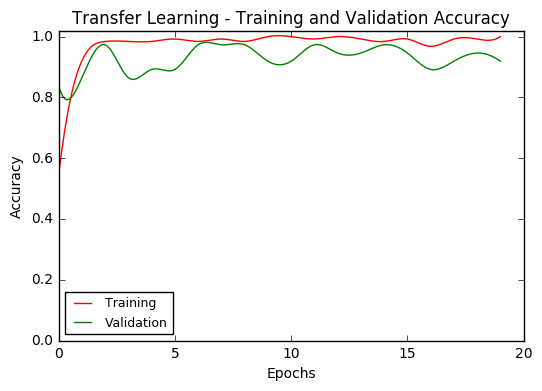

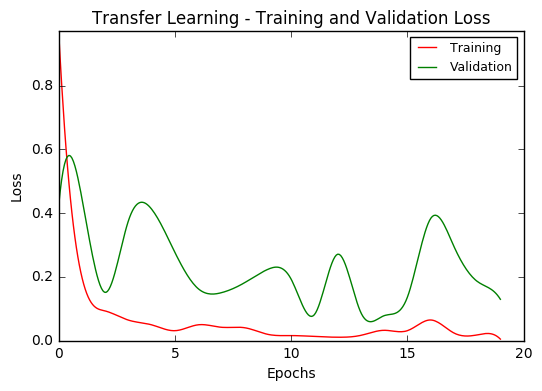

In [23]:
xfer_acc = transfer_learning_history.history['acc']
val_acc = transfer_learning_history.history['val_acc']
xfer_loss = transfer_learning_history.history['loss']
val_loss = transfer_learning_history.history['val_loss']
epochs = range(len(xfer_acc))

x = np.array(epochs)
y = np.array(xfer_acc)
x_smooth = np.linspace(x.min(), x.max(), 300)
y_smooth = spline(x, y, x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_acc)
x1_smooth = np.linspace(x1.min(), x1.max(), 300)
y1_smooth = spline(x1, y1, x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
plt.title('Transfer Learning - Training and Validation Accuracy')
plt.legend(loc = 'lower left', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1.02)

plt.figure()
x = np.array(epochs)
y = np.array(xfer_loss)
x_smooth = np.linspace(x.min(), x.max(), 300)
y_smooth = spline(x, y, x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_loss)
x1_smooth = np.linspace(x1.min(), x1.max(), 300)
y1_smooth = spline(x1, y1, x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
plt.title('Transfer Learning - Training and Validation Loss')
plt.legend(loc = 'upper right', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,max(y))
plt.show()

In [24]:
validate_generator.total_batches_seen

137

In [25]:
predict_files = glob.glob("leaves_test/*.jpg")

In [26]:
im = cv2.imread(predict_files[0])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (256, 256)).astype(np.float32)
im = np.expand_dims(im, axis = 0)/255

In [27]:
predict_files

['leaves_test\\Leaf_01_image_0021.jpg',
 'leaves_test\\Leaf_01_image_0025.jpg',
 'leaves_test\\Leaf_01_image_0040.jpg',
 'leaves_test\\Leaf_01_image_0051.jpg',
 'leaves_test\\Leaf_01_image_0058.jpg',
 'leaves_test\\Leaf_02_image_0102.jpg',
 'leaves_test\\Leaf_02_image_0104.jpg',
 'leaves_test\\Leaf_02_image_0113.jpg',
 'leaves_test\\Leaf_02_image_0119.jpg',
 'leaves_test\\Leaf_02_image_0124.jpg',
 'leaves_test\\Leaf_03_image_0161.jpg',
 'leaves_test\\Leaf_03_image_0164.jpg',
 'leaves_test\\Leaf_03_image_0173.jpg',
 'leaves_test\\Leaf_03_image_0180.jpg',
 'leaves_test\\Leaf_03_image_0184.jpg']

In [28]:
predictor, image_id = [], []
for i in predict_files:
    im = cv2.imread(i)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    outcome = [np.argmax(model.predict(im))]
    predictor.extend(list(outcome))
    image_id.extend([i.rsplit("\\")[-1]])

In [29]:
final = pd.DataFrame()
final["id"] = image_id
final["Leaf"] = predictor 
final.head(15)

,id,Leaf
0,Leaf_01_image_0021.jpg,0
1,Leaf_01_image_0025.jpg,0
2,Leaf_01_image_0040.jpg,0
3,Leaf_01_image_0051.jpg,0
4,Leaf_01_image_0058.jpg,0
5,Leaf_02_image_0102.jpg,1
6,Leaf_02_image_0104.jpg,1
7,Leaf_02_image_0113.jpg,1
8,Leaf_02_image_0119.jpg,1
9,Leaf_02_image_0124.jpg,1


In [31]:
classes = train_generator.class_indices
classes = {value : key for key, value in classes.items()}

In [32]:
final["Leaf"] = final["Leaf"].apply(lambda x: classes[x])
final.head(15)

,id,Leaf
0,Leaf_01_image_0021.jpg,Leaf_01
1,Leaf_01_image_0025.jpg,Leaf_01
2,Leaf_01_image_0040.jpg,Leaf_01
3,Leaf_01_image_0051.jpg,Leaf_01
4,Leaf_01_image_0058.jpg,Leaf_01
5,Leaf_02_image_0102.jpg,Leaf_02
6,Leaf_02_image_0104.jpg,Leaf_02
7,Leaf_02_image_0113.jpg,Leaf_02
8,Leaf_02_image_0119.jpg,Leaf_02
9,Leaf_02_image_0124.jpg,Leaf_02


In [33]:
for i, layer in enumerate(incepV3_model.layers):
   print(i, layer.name)

0 input_1
1 convolution2d_1
2 batchnormalization_1
3 convolution2d_2
4 batchnormalization_2
5 convolution2d_3
6 batchnormalization_3
7 maxpooling2d_1
8 convolution2d_4
9 batchnormalization_4
10 convolution2d_5
11 batchnormalization_5
12 maxpooling2d_2
13 convolution2d_9
14 batchnormalization_9
15 convolution2d_7
16 convolution2d_10
17 batchnormalization_7
18 batchnormalization_10
19 averagepooling2d_1
20 convolution2d_6
21 convolution2d_8
22 convolution2d_11
23 convolution2d_12
24 batchnormalization_6
25 batchnormalization_8
26 batchnormalization_11
27 batchnormalization_12
28 mixed0
29 convolution2d_16
30 batchnormalization_16
31 convolution2d_14
32 convolution2d_17
33 batchnormalization_14
34 batchnormalization_17
35 averagepooling2d_2
36 convolution2d_13
37 convolution2d_15
38 convolution2d_18
39 convolution2d_19
40 batchnormalization_13
41 batchnormalization_15
42 batchnormalization_18
43 batchnormalization_19
44 mixed1
45 convolution2d_23
46 batchnormalization_23
47 convolution2d_

In [34]:
# Step 1 - Set up fine tuning on pre-trained ImageNet Inception_V3 model - freeze lower 94 layers only
for layer in model.layers[:94]:
    layer.trainable = False
for layer in model.layers[94:]:
    layer.trainable = True
    
# Step 2 - Compile the revised model using SGD optimizer with a learing rate of 0.0001 and a momentum of 0.9
model.compile(optimizer = SGD(lr = 0.0001, momentum=0.9), 
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

# Step 3 - Fit the revised model, log the results and the training time
now = datetime.datetime.now
t = now()
fine_tuning_history = model.fit_generator(
    train_generator,
    nb_epoch = nb_epochs,
    samples_per_epoch = nb_train_samples,
    validation_data = validate_generator,
    nb_val_samples = nb_validate_samples,
    class_weight='auto')
print('Training time: %s' % (now() - t))

Epoch 1/20
125/125 [==============================] - 141s - loss: 0.0125 - acc: 1.0000 - val_loss: 0.2310 - val_acc: 0.9459
Epoch 2/20
125/125 [==============================] - 123s - loss: 0.0028 - acc: 1.0000 - val_loss: 0.2013 - val_acc: 0.9459
Epoch 3/20
125/125 [==============================] - 122s - loss: 0.0089 - acc: 1.0000 - val_loss: 0.2411 - val_acc: 0.9189
Epoch 4/20
125/125 [==============================] - 115s - loss: 0.0054 - acc: 1.0000 - val_loss: 0.0677 - val_acc: 0.9730
Epoch 5/20
125/125 [==============================] - 114s - loss: 0.0106 - acc: 1.0000 - val_loss: 0.1415 - val_acc: 0.9730
Epoch 6/20
125/125 [==============================] - 120s - loss: 0.0104 - acc: 0.9920 - val_loss: 0.2586 - val_acc: 0.9189
Epoch 7/20
125/125 [==============================] - 124s - loss: 0.0065 - acc: 1.0000 - val_loss: 0.2075 - val_acc: 0.9459
Epoch 8/20
125/125 [==============================] - 126s - loss: 0.0053 - acc: 1.0000 - val_loss: 0.1249 - val_acc: 0.9459


In [35]:
# evaluate the performance the new model and report the results
score = model.evaluate_generator(validate_generator, nb_validate_samples/batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.0838017314672
Test Accuracy: 0.94594591856


In [36]:
model.save('leaves_inception_v3_model_ft.h5')

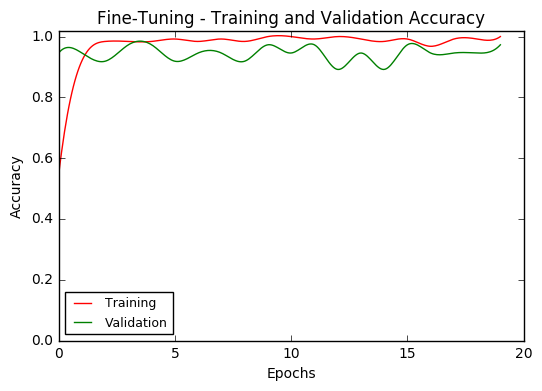

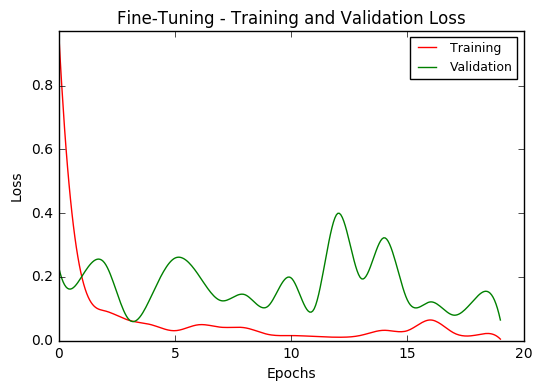

In [37]:
ft_acc = fine_tuning_history.history['acc']
val_acc = fine_tuning_history.history['val_acc']
ft_loss = fine_tuning_history.history['loss']
val_loss = fine_tuning_history.history['val_loss']
epochs = range(len(ft_acc))

x = np.array(epochs)
y = np.array(xfer_acc)
x_smooth = np.linspace(x.min(), x.max(), 300)
y_smooth = spline(x, y, x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_acc)
x1_smooth = np.linspace(x1.min(), x1.max(), 300)
y1_smooth = spline(x1, y1, x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
plt.title('Fine-Tuning - Training and Validation Accuracy')
plt.legend(loc = 'lower left', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1.02)

plt.figure()
x = np.array(epochs)
y = np.array(xfer_loss)
x_smooth = np.linspace(x.min(), x.max(), 300)
y_smooth = spline(x, y, x_smooth)
plt.plot(x_smooth, y_smooth, 'r-', label = 'Training')

x1 = np.array(epochs)
y1 = np.array(val_loss)
x1_smooth = np.linspace(x1.min(), x1.max(), 300)
y1_smooth = spline(x1, y1, x1_smooth)

plt.plot(x1_smooth, y1_smooth, 'g-', label = 'Validation')
plt.title('Fine-Tuning - Training and Validation Loss')
plt.legend(loc = 'upper right', fontsize = 9)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,max(y))
plt.show()

In [38]:
validate_generator.total_batches_seen

279

In [39]:
# predict unseen images
predict_files = glob.glob("leaves_test/*.jpg")

In [40]:
im = cv2.imread(predict_files[0])
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (256, 256)).astype(np.float32)
im = np.expand_dims(im, axis = 0)/255

In [41]:
predictor, image_id = [], []
for i in predict_files:
    im = cv2.imread(i)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    outcome = [np.argmax(model.predict(im))]
    predictor.extend(list(outcome))
    image_id.extend([i.rsplit("\\")[-1]])

In [42]:
final = pd.DataFrame()
final["id"] = image_id
final["Leaf"] = predictor 
final.head(15)

,id,Leaf
0,Leaf_01_image_0021.jpg,0
1,Leaf_01_image_0025.jpg,0
2,Leaf_01_image_0040.jpg,0
3,Leaf_01_image_0051.jpg,0
4,Leaf_01_image_0058.jpg,0
5,Leaf_02_image_0102.jpg,1
6,Leaf_02_image_0104.jpg,1
7,Leaf_02_image_0113.jpg,1
8,Leaf_02_image_0119.jpg,1
9,Leaf_02_image_0124.jpg,1


In [43]:
classes = train_generator.class_indices
classes = {value : key for key, value in classes.items()}

In [44]:
final["Leaf"] = final["Leaf"].apply(lambda x: classes[x])
final.head(15)

,id,Leaf
0,Leaf_01_image_0021.jpg,Leaf_01
1,Leaf_01_image_0025.jpg,Leaf_01
2,Leaf_01_image_0040.jpg,Leaf_01
3,Leaf_01_image_0051.jpg,Leaf_01
4,Leaf_01_image_0058.jpg,Leaf_01
5,Leaf_02_image_0102.jpg,Leaf_02
6,Leaf_02_image_0104.jpg,Leaf_02
7,Leaf_02_image_0113.jpg,Leaf_02
8,Leaf_02_image_0119.jpg,Leaf_02
9,Leaf_02_image_0124.jpg,Leaf_02
